<img src="../../images/qiskit-heading.gif" width="500px" align="left">

# Terra 0.8 - Circuit API Updates

In this tutorial, we'll introduce three new components of the Terra circuit building API, added in the Terra 0.8 release with the goal of facilitating circuit construction, reducing boilerplate, and aiding reuse through composition and parameterization.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

## 1. Optional registers

When not planning to make use of multiple registers, register declarations amount to unneeded overhead.
Terra 0.8 adds more concise syntax to create and build circuits without explicit register declaration.

### Registerless `QuantumCircuit` declaration

An alternate constructor has been added to `QuantumCircuit` which accepts one or two integers, the number of qubits (required) and the number of classical bits or clbits (optional).

In [3]:
qc = QuantumCircuit(3, 2)

will create a quantum circuit equivalent to the following (still valid) circuit declaration:

In [2]:
qr = QuantumRegister(3, name='q')
cr = ClassicalRegister(2, name='c')
qc = QuantumCircuit(qr, cr)

Registers are automatically generated based on qubit/clbit count, and can be accessed through the circuit as needed.

In [4]:
print(qc.qregs)
print(qc.cregs)

[QuantumRegister(3, 'q')]
[ClassicalRegister(2, 'c')]


### Index-based addressing

Similarly, qubits and clbits can now be addressed directly by index, without need for referencing a register.

In [1]:
bell = QuantumCircuit(2,2)
bell.h(0)
bell.cx(0, 1)
bell.measure([0,1], [0,1])

bell.draw()

NameError: name 'QuantumCircuit' is not defined

The gate type will determine if an index references a qubit or a cbit (e.g. `cx` expects `(qubit, qubit)`, `measure` expects `(qubit, clbit)`). This syntax works with both forms of `QuantumCircuit` construction, and users can freely switch between register-based an index-based commands as convenient.

In circuits with multiple registers, index ordering will be set by the order in which registers were added to the circuit, and can be verified by inspecting the circuit's `qubits` and `clbits` properties.

In [9]:
print('Qubit ordering:', bell.qubits)
print('Classical bit ordering:', bell.clbits)


Qubit ordering: [(QuantumRegister(2, 'q'), 0), (QuantumRegister(2, 'q'), 1)]
Classical bit ordering: [(ClassicalRegister(2, 'c'), 0), (ClassicalRegister(2, 'c'), 1)]


## 2. Portable `Instruction`s and `CompositeGate` replacement

Starting in Terra 0.8, `Instruction` instances have become more portable and serve as a basis for composing re-usable circuit components through `QuantumCircuit.append`.

### Opaque gates

The `Gate` and `Instruction` constructors now take two integers as arguments, a number of qubits and number of classical bits, defining the gates quantum and classical width.

In [4]:
from qiskit.circuit import Gate

my_gate = Gate(name='my_gate', num_qubits=2, params=[])

An `append(instruction, qargs, cargs)` method has been added to the `QuantumCircuit` class, which takes an anonymous `Instruction` instance and attaches it to the circuit at the specified `qargs` and `cargs`.

In [2]:
qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.append(my_gate, [qr[0], qr[1]])
circ.append(my_gate, [qr[1], qr[2]])

circ.draw()

NameError: name 'QuantumRegister' is not defined

### Composite Gates

Circuit subcomponents can be constrcuted as `QuantumCircuit` instances, and then converted to `Instruction` instances through `to_instruction` which can be bound to other circuits.

In [5]:
# build a sub-circuit
sub_q = QuantumRegister(2)
sub_circ = QuantumCircuit(sub_q, name='sub_circ')
sub_circ.h(sub_q[0])
sub_circ.crz(1, sub_q[0], sub_q[1])
sub_circ.barrier()
sub_circ.iden(sub_q[1])
sub_circ.u3(1, 2, -2, sub_q[0]) # TODO Sub_circ's u3 params are promoted to be params of sub_circ

# convert to a gate and stick it into an arbitrary place in the bigger circuit
sub_inst = sub_circ.to_instruction()
q = QuantumRegister(3,'q')
circ = QuantumCircuit(q)
circ.append(sub_inst, [q[1], q[2]])

circ.draw()


NameError: name 'QuantumRegister' is not defined

Circuits are not immediately decomposed upon conversion `to_instruction`, to allwo circuit design at an increasing levels of abstrction. When desired, or before compilation, sub-circuits will be decomposed via `decompose`.  

In [6]:
dcirc = circ.decompose() # Does not modify original circuit
dcirc.draw()

NameError: name 'circ' is not defined

## 3. Parameterized circuits

Parameterization is a common feature of many quantum algorithms, as well as a standard building block for construction collections of standard gates and subcircuits into a circuit library.

Terra 0.8 introduces a `Parameter` class which can be used to specify a place holder wherever a numeric constant could be used.

In [16]:
from qiskit.circuit import Parameter

theta = Parameter('θ')

n = 5

qc = QuantumCircuit(5, 1)
qr = qc.qregs[0]

qc.h(0)

for i in range(n-1):
    qc.cx(i, i+1)

qc.barrier()
qc.rz(theta, range(5))
qc.barrier()

for i in reversed(range(n-1)):
    qc.cx(i, i+1)

qc.h(0)
qc.measure(0, 0)

qc.draw()

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[1];
h q[0];
cx q[0],q[1];
cx q[1],q[2];
cx q[2],q[3];
cx q[3],q[4];
barrier q[0],q[1],q[2],q[3],q[4];
rz(θ) q[0];
rz(θ) q[1];
rz(θ) q[2];
rz(θ) q[3];
rz(θ) q[4];
barrier q[0],q[1],q[2],q[3],q[4];
cx q[3],q[4];
cx q[2],q[3];
cx q[1],q[2];
cx q[0],q[1];
h q[0];
measure q[0] -> c[0];



In the above example, we want to quickly construct a series of experiments which will vary the angle of a global $R_z$ rotation. We can inspect the parameters

In [17]:
print(qc.parameters)

{Parameter(θ)}


All circuit parameters must be bound before sending the circuit to a backend. This can be done in one of two ways:
- The `bind_parameters` function accepts a dictionary mapping `Parameter`s to values, and returns new copy of the circuit with each parameter replaced with its matching value. Partial assignment is supported, in which case a new  circuit will be returned, parameterized by any `Parameter`s which were not mapped to a value.

In [18]:
import numpy as np

theta_range = np.linspace(0, 2 * np.pi, 128)
circuits = [qc.bind_parameters({theta: theta_val})
            for theta_val in theta_range]

# print(circuits[-1].qasm().replace('\n', '\n'))
print(circuits[-1].draw(line_length=120))
print(circuits[-1].parameters)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[1];
h q[0];
cx q[0],q[1];
cx q[1],q[2];
cx q[2],q[3];
cx q[3],q[4];
barrier q[0],q[1],q[2],q[3],q[4];
rz(6.283185307179586) q[0];
rz(6.283185307179586) q[1];
rz(6.283185307179586) q[2];
rz(6.283185307179586) q[3];
rz(6.283185307179586) q[4];
barrier q[0],q[1],q[2],q[3],q[4];
cx q[3],q[4];
cx q[2],q[3];
cx q[1],q[2];
cx q[0],q[1];
h q[0];
measure q[0] -> c[0];

        ┌───┐                     ░ ┌────────────┐ ░                     ┌───┐┌─┐
q_0: |0>┤ H ├──■──────────────────░─┤ Rz(6.2832) ├─░──────────────────■──┤ H ├┤M├
        └───┘┌─┴─┐                ░ ├────────────┤ ░                ┌─┴─┐└───┘└╥┘
q_1: |0>─────┤ X ├──■─────────────░─┤ Rz(6.2832) ├─░─────────────■──┤ X ├──────╫─
             └───┘┌─┴─┐           ░ ├────────────┤ ░           ┌─┴─┐└───┘      ║ 
q_2: |0>──────────┤ X ├──■────────░─┤ Rz(6.2832) ├─░────────■──┤ X ├───────────╫─
                  └───┘┌─┴─┐      ░ ├────────────┤ ░      ┌─┴─┐└───┘           ║ 
q_3: |0>─

### Support for parameterized circuits in either assemble circuits and execute

- execute should be smart enough to compile/assign/compile correctly for parameterized circuits
- if you assemble, you have to manage transpile/assign/transpile/assemble 

- `qiskit.execute` and `qiskit.compiler.assemble` both accept a `parameter_binds` keyword argumend, a list of dictionaries mapping `Parameter`s to values. Each dictionary in the `parameter_binds` list will be expanded and executed as a single circuit on the backend.

In [19]:
from qiskit import BasicAer, execute

## Following are equivalent:
# job = execute(circuits, backend=BasicAer.get_backend('qasm_simulator'))
job = execute(qc,
              backend=BasicAer.get_backend('qasm_simulator'),
              parameter_binds=[{theta: theta_val} for theta_val in theta_range])

# TODO Bindings are lost after `assign_variables`, (user has to track experiment order to know which experiments ran with which binds)
counts = [job.result().get_counts(i) for i in range(len(job.result().results))]


In the example circuit considered so far, we apply a global $R_z(\theta)$ rotation on 5-qubit entangled state, and so expect to see oscillation in qubit-0 at $5\theta$.

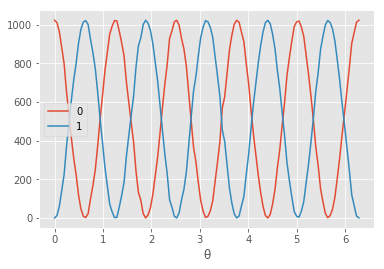

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
plt.style.use('ggplot')

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(theta_range, list(map(lambda c: c.get('0', 0), counts)), '.-', label='0')
ax.plot(theta_range, list(map(lambda c: c.get('1', 0), counts)), '.-', .label='1') 

ax.set_xlabel('θ')
ax.legend()
plt.show()

### Composition

Parameterized circuits can be composed just like other circuits. Generally, when composing circuits two parameterized circuits, the resulting circuit will be parameterized by the union of parameters of source circuits.

If the two source circuits have a parameter of the same name:
 - If it's a different Parameter instance, an error will be raised
 - If it's the same Parameter instance, the new instruction will add to the circuit, parameterized by the circuits original θ


### Compilation cost

Compiling over a parameterized circuit and then binding parameters can, in some cases, significantly reduce compilation time as compared to compiling a set of independent circuits. Some optimizations may be disabled or less effective over parameterized circuits, so in cases where optimal device is required, a second round of compilation may be required.

In [14]:
import time
from itertools import combinations
from qiskit.compiler import transpile
from qiskit.test.mock import FakeTokyo

start = time.time()
qcs = []
for n in np.linspace(0, 2*np.pi, 64):
    qc = QuantumCircuit(20)
    theta = Parameter('theta')
    for k in range(128):
        for i,j in combinations(range(20), 2):
            qc.cx(i,j)
        qc.rz(n, range(20))
        for i,j in combinations(range(20), 2):
            qc.cx(i,j)

    #qcs = [qc.bind_parameters({theta: n})
    #   for n in np.linspace(0, 2*np.pi, 64)]
    compiled_circuit = transpile(qc, {'backend': FakeTokyo()}) # TODO Should be a transpileConfig?
    qcs.append(qc)
end = time.time()
print(end-start)

627.6678950786591


In [ ]:
start = time.time()
qc = QuantumCircuit(20)
theta = Parameter('theta')
for k in range(128):
    for i,j in combinations(range(20), 2):
        qc.cx(i,j)
    qc.rz(theta, range(20))
    for i,j in combinations(range(20), 2):
        qc.cx(i,j)

qc1 = transpile(qc, {'backend': FakeTokyo()})
compiled_circuits = assemble([qc1.bind_parameters({theta: n}) for n in np.linspace(0, 2*np.pi, 64)], {'backend': FakeTokyo()})
end = time.time()
print(end-start)

## Bringing it all together: QPE Demo

In [ ]:
p = Parameter('p')
qc = QuantumCircuit(3)
qc.rz(p, 0)
qc.cx(0, 1)
qc.rz(p, 1)
qc.cx(1, 2)
qc.rz(p, 2)

theta = Parameter('theta')
phi = Parameter('phi')
gamma = Parameter('gamma')

qr = QuantumRegister(9)
larger_qc = QuantumCircuit(qr)
larger_qc.append(qc.to_instruction({p: theta}), qr[0:3])
larger_qc.append(qc.to_instruction({p: phi}), qr[3:6])
larger_qc.append(qc.to_instruction({p: gamma}, qr[6:9])
print(larger_qc.draw())

         ┌──────────────────┐
q0_0: |0>┤0                 ├
         │                  │
q0_1: |0>┤1 circuit1(theta) ├
         │                  │
q0_2: |0>┤2                 ├
         └┬────────────────┬┘
q0_3: |0>─┤0               ├─
          │                │
q0_4: |0>─┤1 circuit1(phi) ├─
          │                │
q0_5: |0>─┤2               ├─
         ┌┴────────────────┴┐
q0_6: |0>┤0                 ├
         │                  │
q0_7: |0>┤1 circuit1(gamma) ├
         │                  │
q0_8: |0>┤2                 ├
         └──────────────────┘

print(larger_qc.decompose().draw())
         ┌───────────┐
q0_0: |0>┤ Rz(theta) ├──■─────────────────────────────────
         └───────────┘┌─┴─┐┌───────────┐
q0_1: |0>─────────────┤ X ├┤ Rz(theta) ├──■───────────────
                      └───┘└───────────┘┌─┴─┐┌───────────┐
q0_2: |0>───────────────────────────────┤ X ├┤ Rz(theta) ├
          ┌─────────┐                   └───┘└───────────┘
q0_3: |0>─┤ Rz(phi) ├───■─────────────────────────────────
          └─────────┘ ┌─┴─┐ ┌─────────┐
q0_4: |0>─────────────┤ X ├─┤ Rz(phi) ├───■───────────────
                      └───┘ └─────────┘ ┌─┴─┐ ┌─────────┐
q0_5: |0>───────────────────────────────┤ X ├─┤ Rz(phi) ├─
         ┌───────────┐                  └───┘ └─────────┘
q0_6: |0>┤ Rz(gamma) ├──■─────────────────────────────────
         └───────────┘┌─┴─┐┌───────────┐
q0_7: |0>─────────────┤ X ├┤ Rz(gamma) ├──■───────────────
                      └───┘└───────────┘┌─┴─┐┌───────────┐
q0_8: |0>───────────────────────────────┤ X ├┤ Rz(gamma) ├
                                        └───┘└───────────┘


In [ ]:
.to_instruction()

In [ ]:

parameter copy
__add__

In [ ]:
Two examples, have an instruction/circuit, where I want to repeat it sharing the parameter
where I want to repeat it with different parameters

copy => new param
one option, append requires params if parameterized

still need a way to bind_parameters

inverse


In [ ]:
>>> qc = qk.QuantumCircuit(3)
>>> qc.cx(0, 1)
<qiskit.extensions.standard.cx.CnotGate object at 0x12842f470>
>>> qc.cx(1, 2)
<qiskit.extensions.standard.cx.CnotGate object at 0x119457898>
>>> shingle = qc.to_instruction()
>>> qc = qk.QuantumCircuit(5)
>>> qr = qc.qregs[0]
>>> qc.append(shingle, [qr[0],qr[1],qr[2]])
<qiskit.circuit.instruction.Instruction object at 0x10c441240>
>>> qc.append(shingle, qr[1:4])
<qiskit.circuit.instruction.Instruction object at 0x10c441240>
>>> qc.append(shingle, qr[2:5])
<qiskit.circuit.instruction.Instruction object at 0x10c441240>
>>> print(qc)
        ┌────────────┐
q_0: |0>┤0           ├────────────────────────────
        │            │┌────────────┐
q_1: |0>┤1 circuit13 ├┤0           ├──────────────
        │            ││            │┌────────────┐
q_2: |0>┤2           ├┤1 circuit13 ├┤0           ├
        └────────────┘│            ││            │
q_3: |0>──────────────┤2           ├┤1 circuit13 ├
                      └────────────┘│            │
q_4: |0>────────────────────────────┤2           ├
                                    └────────────┘
                        

adv register indexing would be better here, qr[1:], qr[:-1]